In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc , confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop

from dataset_preparation import awgn, LoadDataset, ChannelIndSpectrogram
from deep_learning_models import TripletNet, identity_loss

In [3]:
def train_feature_extractor(
        file_path = './dataset/Train/dataset_training_aug.h5', 
        dev_range = np.arange(0,30, dtype = int), 
        pkt_range = np.arange(0,1000, dtype = int), 
        snr_range = np.arange(20,80)
                            ):
    '''
    train_feature_extractor trains an RFF extractor using triplet loss.
    
    INPUT: 
        FILE_PATH is the path of training dataset.
        
        DEV_RANGE is the label range of LoRa devices to train the RFF extractor.
        
        PKT_RANGE is the range of packets from each LoRa device to train the RFF extractor.
        
        SNR_RANGE is the SNR range used in data augmentation. 
        
    RETURN:
        FEATURE_EXTRACTOR is the RFF extractor which can extract features from
        channel-independent spectrograms.
    '''
    
    LoadDatasetObj = LoadDataset()
    
    # Load preamble IQ samples and labels.
    data, label = LoadDatasetObj.load_iq_samples(file_path, 
                                                 dev_range, 
                                                 pkt_range)
    
    # Add additive Gaussian noise to the IQ samples.
    data = awgn(data, snr_range)
    
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert time-domain IQ samples to channel-independent spectrograms.
    data = ChannelIndSpectrogramObj.channel_ind_spectrogram(data)
    
    # Specify hyper-parameters during training.
    margin = 0.1
    batch_size = 32
    patience = 20
    
    TripletNetObj = TripletNet()
    
    # Create an RFF extractor.
    feature_extractor = TripletNetObj.feature_extractor(data.shape)
    
    # Create the Triplet net using the RFF extractor.
    triplet_net = TripletNetObj.create_triplet_net(feature_extractor, margin)

    # Create callbacks during training. The training stops when validation loss 
    # does not decrease for 30 epochs.
    early_stop = EarlyStopping('val_loss', 
                               min_delta = 0, 
                               patience = 
                               patience)
    
    reduce_lr = ReduceLROnPlateau('val_loss', 
                                  min_delta = 0, 
                                  factor = 0.2, 
                                  patience = 10, 
                                  verbose=1)
    callbacks = [early_stop, reduce_lr]
    
    # Split the dasetset into validation and training sets.
    data_train, data_valid, label_train, label_valid = train_test_split(data, 
                                                                        label, 
                                                                        test_size=0.1, 
                                                                        shuffle= True)
    del data, label
    
    # Create the trainining generator.
    train_generator = TripletNetObj.create_generator(batch_size, 
                                                     dev_range, 
                                                     data_train, 
                                                     label_train)
    # Create the validation generator.
    valid_generator = TripletNetObj.create_generator(batch_size, 
                                                     dev_range, 
                                                     data_valid, 
                                                     label_valid)
    
    
    # Use the RMSprop optimizer for training.
    opt = RMSprop(learning_rate=1e-3)
    triplet_net.compile(loss = identity_loss, optimizer = opt)

    # Start training.
    history = triplet_net.fit(train_generator,
                              steps_per_epoch = data_train.shape[0]//batch_size,
                              epochs = 1000,
                              validation_data = valid_generator,
                              validation_steps = data_valid.shape[0]//batch_size,
                              verbose=1, 
                              callbacks = callbacks)
    
    return feature_extractor

def test_classification(
        file_path_enrol,
        file_path_clf,
        feature_extractor_name,
        dev_range_enrol = np.arange(30,40, dtype = int),
        pkt_range_enrol = np.arange(0,100, dtype = int),
        dev_range_clf = np.arange(30,40, dtype = int),
        pkt_range_clf = np.arange(100,200, dtype = int)
                        ):
    '''
    test_classification performs a classification task and returns the 
    classification accuracy.
    
    INPUT: 
        FILE_PATH_ENROL is the path of enrollment dataset.
        
        FILE_PATH_CLF is the path of classification dataset.
        
        FEATURE_EXTRACTOR_NAME is the name of RFF extractor used during 
        enrollment and classification. 
        
        DEV_RANGE_ENROL is the label range of LoRa devices during enrollment.
        
        PKT_RANGE_ENROL is the range of packets from each LoRa device during enrollment.
        
        DEV_RANGE_CLF is the label range of LoRa devices during classification.
        
        PKT_RANGE_CLF is the range of packets from each LoRa device during classification.

    RETURN:
        PRED_LABEL is the list of predicted labels.
        
        TRUE_LABEL is the list true labels.
        
        ACC is the overall classification accuracy.
    '''
    
    # Load the saved RFF extractor.
    feature_extractor = load_model(feature_extractor_name, compile=False)
    
    LoadDatasetObj = LoadDataset()
    
    # Load the enrollment dataset. (IQ samples and labels)
    data_enrol, label_enrol = LoadDatasetObj.load_iq_samples(file_path_enrol, 
                                                             dev_range_enrol, 
                                                             pkt_range_enrol)
    
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert IQ samples to channel independent spectrograms. (enrollment data)
    data_enrol = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_enrol)
    
    # # Visualize channel independent spectrogram
    # plt.figure()
    # sns.heatmap(data_enrol[0,:,:,0],xticklabels=[], yticklabels=[], cmap='Blues', cbar=False)
    # plt.gca().invert_yaxis()
    # plt.savefig('channel_ind_spectrogram.pdf')
    
    # Extract RFFs from channel independent spectrograms.
    feature_enrol = feature_extractor.predict(data_enrol)
    del data_enrol
    
    # Create a K-NN classifier using the RFFs extracted from the enrollment dataset.
    knnclf=KNeighborsClassifier(n_neighbors=15,metric='euclidean')
    knnclf.fit(feature_enrol, np.ravel(label_enrol))
    
    
    # Load the classification dataset. (IQ samples and labels)
    data_clf, true_label = LoadDatasetObj.load_iq_samples(file_path_clf, 
                                                         dev_range_clf, 
                                                         pkt_range_clf)
    
    # Convert IQ samples to channel independent spectrograms. (classification data)
    data_clf = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_clf)

    # Extract RFFs from channel independent spectrograms.
    feature_clf = feature_extractor.predict(data_clf)
    del data_clf
    
    # Make prediction using the K-NN classifier.
    pred_label = knnclf.predict(feature_clf)

    # Calculate classification accuracy.
    acc = accuracy_score(true_label, pred_label)
    print('Overall accuracy = %.4f' % acc)
    
    return pred_label, true_label, acc

def test_rogue_device_detection(
    feature_extractor_name,
    file_path_enrol = './dataset/Test/dataset_residential.h5',
    dev_range_enrol = np.arange(30,40, dtype = int),
    pkt_range_enrol = np.arange(0,100, dtype = int),
    file_path_legitimate = './dataset/Test/dataset_residential.h5',
    dev_range_legitimate = np.arange(30,40, dtype = int),
    pkt_range_legitimate = np.arange(100,200, dtype = int),
    file_path_rogue = './dataset/Test/dataset_rogue.h5',
    dev_range_rogue = np.arange(40,45, dtype = int),
    pkt_range_rogue = np.arange(0,100, dtype = int),
    ):

    '''
    test_rogue_device_detection performs the rogue device detection task using
    a specific RFF extractor. It returns false positive rate (FPR), true 
    positive rate (TPR), area under the curve (AUC) and corresponding threshold 
    settings.
    
    INPUT: 
    
        FEATURE_EXTRACTOR_NAME is the name of RFF extractor used in rogue 
        device detection.
        
        FILE_PATH_ENROL is the path of enrollment dataset.
        
        DEV_RANGE_ENROL is the device index range used in the enrollment stage.
        
        PKT_RANGE_ENROL is the packet index range used in the enrollment stage.
        
        FILE_PATH_LEGITIMATE is the path of dataset contains packets from
        legitimate devices.
        
        DEV_RANGE_LEGITIMATE is the index range of legitimate devices used in
        the rogue device detection stage.
        
        PKT_RANGE_LEGITIMATE specifies the packet range from legitimate devices 
        used in the rogue device detection stage.
        
        FILE_PATH_ROGUE is the path of dataset contains packets from rogue 
        devices.
        
        DEV_RANGE_ROGUE is the index range of rogue devices used in the rogue 
        device detection stage.
        
        PKT_RANGE_ROGUE specifies the packet range from rogue devices used in 
        the rogue device detection stage.
    
    RETURN:
        FPR is the detection false positive rate.
        
        TRP is the detection true positive rate.

        ROC_AUC is the area under the ROC curve.
        
        EER is the equal error rate.
        
    '''

    
    def _compute_eer(fpr,tpr,thresholds):
        '''
        _COMPUTE_EER returns equal error rate (EER) and the threshold to reach
        EER point.
        '''
        fnr = 1-tpr
        abs_diffs = np.abs(fpr - fnr)
        min_index = np.argmin(abs_diffs)
        eer = np.mean((fpr[min_index], fnr[min_index]))
        
        return eer, thresholds[min_index]
    
    # Load RFF extractor.
    feature_extractor = load_model(feature_extractor_name, compile=False)
    
    LoadDatasetObj = LoadDataset()
    
    # Load enrollment dataset.
    data_enrol, label_enrol = LoadDatasetObj.load_iq_samples(file_path_enrol, 
                                                             dev_range_enrol, 
                                                             pkt_range_enrol)
    
    ChannelIndSpectrogramObj = ChannelIndSpectrogram()
    
    # Convert IQ samples to channel independent spectrograms.
    data_enrol = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_enrol)
    
    # Extract RFFs from cahnnel independent spectrograms.
    feature_enrol = feature_extractor.predict(data_enrol)
    del data_enrol
    
    # Build a K-NN classifier.
    knnclf=KNeighborsClassifier(n_neighbors=15,metric='euclidean')
    knnclf.fit(feature_enrol, np.ravel(label_enrol))
    
    # Load the test dataset of legitimate devices.
    data_legitimate, label_legitimate = LoadDatasetObj.load_iq_samples(file_path_legitimate, 
                                                                       dev_range_legitimate, 
                                                                       pkt_range_legitimate)
    # Load the test dataset of rogue devices.
    data_rogue, label_rogue = LoadDatasetObj.load_iq_samples(file_path_rogue, 
                                                             dev_range_rogue, 
                                                             pkt_range_rogue)
    
    # Combine the above two datasets into one dataset containing both rogue
    # and legitimate devices.
    data_test = np.concatenate([data_legitimate,data_rogue])
    label_test = np.concatenate([label_legitimate,label_rogue])
    
    # Convert IQ samples to channel independent spectrograms.
    data_test = ChannelIndSpectrogramObj.channel_ind_spectrogram(data_test)

    # Extract RFFs from channel independent spectrograms.
    feature_test = feature_extractor.predict(data_test)
    del data_test

    # Find the nearest 15 neighbors in the RFF database and calculate the 
    # distances to them.
    distances, indexes = knnclf.kneighbors(feature_test)
    
    # Calculate the average distance to the nearest 15 neighbors.
    detection_score = distances.mean(axis =1)

    # Label the packets sent from legitimate devices as 1. The rest are sent by rogue devices
    # and are labeled as 0.
    true_label = np.zeros([len(label_test),1])
    true_label[(label_test <= dev_range_legitimate[-1]) & (label_test >= dev_range_legitimate[0])] = 1
    
    # Compute receiver operating characteristic (ROC).
    fpr, tpr, thresholds = roc_curve(true_label, detection_score, pos_label = 1)
    
    # The Euc. distance is used as the detection score. The lower the value, 
    # the more similar it is. This is opposite with the probability or confidence 
    # value used in scikit-learn roc_curve function. Therefore, we need to subtract 
    # them from 1.
    fpr = 1-fpr  
    tpr = 1-tpr

    # Compute EER.
    eer, _ = _compute_eer(fpr,tpr,thresholds)
    
    # Compute AUC.
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, eer
    

Dataset information: Dev 1 to Dev 30, 500 packets per device.
Epoch 1/1000
421/421 [==============================] - 9s 16ms/step - loss: 0.1002 - val_loss: 0.1000 - lr: 0.0010
Epoch 2/1000
421/421 [==============================] - 7s 17ms/step - loss: 0.1000 - val_loss: 0.1000 - lr: 0.0010
Epoch 3/1000
421/421 [==============================] - 7s 16ms/step - loss: 0.1000 - val_loss: 0.1000 - lr: 0.0010
Epoch 4/1000
421/421 [==============================] - 7s 17ms/step - loss: 0.1000 - val_loss: 0.1000 - lr: 0.0010
Epoch 5/1000
421/421 [==============================] - 7s 17ms/step - loss: 0.1000 - val_loss: 0.0997 - lr: 0.0010
Epoch 6/1000
421/421 [==============================] - 7s 16ms/step - loss: 0.0998 - val_loss: 0.0983 - lr: 0.0010
Epoch 7/1000
421/421 [==============================] - 7s 16ms/step - loss: 0.0984 - val_loss: 0.0999 - lr: 0.0010
Epoch 8/1000
421/421 [==============================] - 7s 16ms/step - loss: 0.0851 - val_loss: 0.0787 - lr: 0.0010
Epoch 9/10

/home/smazokha2016/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Dataset information: Dev 31 to Dev 40, 400 packets per device.
32/32 [==============================] - 0s 2ms/step
Dataset information: Dev 31 to Dev 40, 200 packets per device.
32/32 [==============================] - 0s 2ms/step
Overall accuracy = 0.8500


Text(50.722222222222214, 0.5, 'True label')

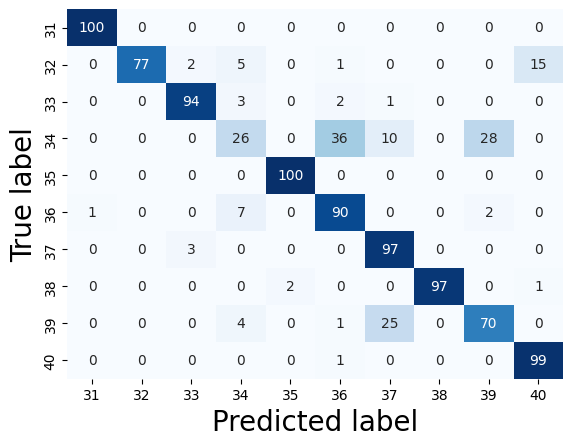

In [15]:
ROOT_PATH = '/home/smazokha2016/Desktop/lora_dataset'

# Augmented dataset: 1000 packets per device (both aug, and aug_0hz)
# Non-augmented dataset: 500 packets per device
# dataset_train = os.path.join(ROOT_PATH, 'Train', 'dataset_training_aug.h5')
dataset_train = os.path.join(ROOT_PATH, 'Train', 'dataset_training_no_aug.h5')
model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_no_aug.h5')
# model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_aug.h5')

feature_extractor = train_feature_extractor(dataset_train, np.arange(0, 30), np.arange(0, 500), np.arange(20, 80))
feature_extractor.save(model_path)

Dataset information: Dev 31 to Dev 40, 200 packets per device.
32/32 [==============================] - 0s 2ms/step
Dataset information: Dev 31 to Dev 40, 200 packets per device.
32/32 [==============================] - 0s 2ms/step
Overall accuracy = 0.9450


Text(50.722222222222214, 0.5, 'True label')

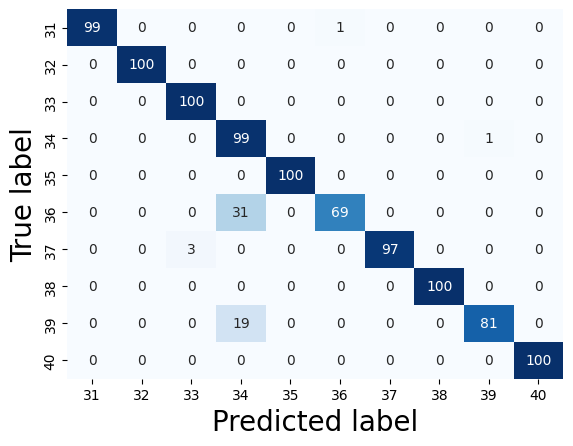

In [24]:
model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_no_aug.h5')
# model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_aug.h5')

# dataset_enrol = os.path.join(ROOT_PATH, 'Test', 'dataset_residential.h5')
dataset_enrol = os.path.join(ROOT_PATH, 'Test', 'channel_problem', 'E.h5')
dataset_clf = os.path.join(ROOT_PATH, 'Test', 'channel_problem', 'F.h5')

pred_label, true_label, acc = test_classification(dataset_enrol, dataset_clf, model_path)
    
# Plot the confusion matrix.
conf_mat = confusion_matrix(true_label, pred_label)
classes = np.arange(30, 40) + 1

plt.figure()
sns.heatmap(conf_mat, annot=True, 
            fmt = 'd', cmap='Blues',
            cbar = False,
            xticklabels=classes, 
            yticklabels=classes)
plt.xlabel('Predicted label', fontsize = 20)
plt.ylabel('True label', fontsize = 20)

In [32]:
dataset = os.path.join(ROOT_PATH, 'Test', 'channel_problem', 'F.h5')
data, _ = LoadDataset().load_iq_samples(dataset, np.arange(30, 40), np.arange(0, 100))

Dataset information: Dev 31 to Dev 40, 200 packets per device.


Dataset information: Dev 31 to Dev 40, 400 packets per device.


32/32 [==============================] - 0s 2ms/step
Dataset information: Dev 41 to Dev 45, 200 packets per device.
16/16 [==============================] - 0s 2ms/step


(0.0, 2.0)

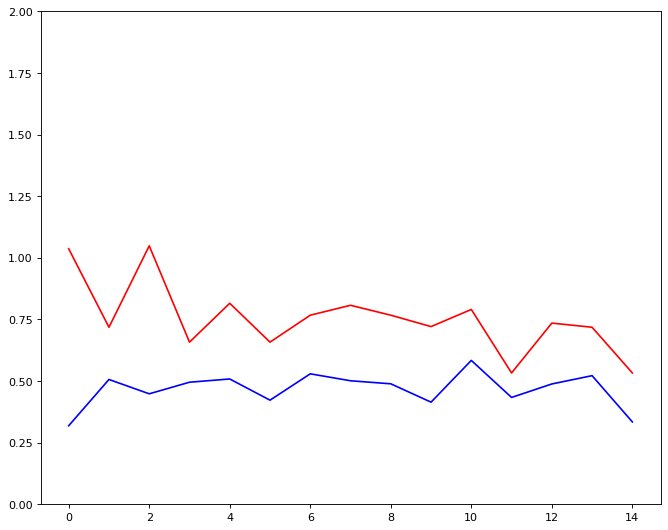

In [40]:
from scipy.spatial.distance import pdist, squareform, cdist

# model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_no_aug.h5')
model_path = os.path.join(ROOT_PATH, 'my_models', 'extractor_aug.h5')
feature_extractor = load_model(model_path, compile=False)

dev_range = np.arange(30, 40)
pkt_range = np.arange(0, 100)
fp_len = 512

def get_fingerprints(dataset_name, dev_range, pkt_range, fp_len):
    # dataset = os.path.join(ROOT_PATH, 'Test', 'channel_problem', dataset_name)
    dataset = os.path.join(ROOT_PATH, 'Test', dataset_name)
    data, _ = LoadDataset().load_iq_samples(dataset, dev_range, pkt_range)
    data_spectrograms = ChannelIndSpectrogram().channel_ind_spectrogram(data)
    return feature_extractor.predict(data_spectrograms).reshape(len(dev_range), len(pkt_range), fp_len)

def evaluate_fingerprint_similarity(dev_range, fingerprints, device_idx, ref_epoch_idx):
    N, M, K, D = fingerprints.shape

    # Extract reference fingerprints at device_idx and epoch_idx
    reference_fingerprints = fingerprints[device_idx, ref_epoch_idx, :, :]

    # Initialize a matrix to store average distances with respect to reference fingerprints
    avg_distances = np.zeros((N, M))

    # Compute average Euclidean distance with respect to reference fingerprints for each device and epoch
    for i in range(N):
        for j in range(M):
            # Extract the K fingerprints for device i at epoch j
            data = fingerprints[i, j, :, :]
            # Compute the Euclidean distances between reference fingerprints and current fingerprints
            distances = cdist(reference_fingerprints, data, 'euclidean')
            # Average the distances
            avg_distance = np.mean(distances)
            avg_distances[i, j] = avg_distance

    device_distances = np.mean(avg_distances, axis=1)
    device_distances.sort()

    # # Plot the heatmaps side by side
    # fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # # Plot the heatmap
    # sns.heatmap(avg_distances, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Average Euclidean Distance with Respect to Reference'}, yticklabels=dev_range, ax=axes[0])
    # axes[0].set_title(f'Average Euclidean Distance of Fingerprints Across Devices and Epochs\n(Reference: device={dev_range[device_idx]}, epoch={ref_epoch_idx})')
    # axes[0].set_xlabel('Epoch')
    # axes[0].set_ylabel('Device')

    # # Plot the bar chart
    # axes[1].bar(np.arange(avg_distances.shape[0]), device_distances)
    # axes[1].set_title(f"Device fingerprint comparison\n(Reference: device={dev_range[device_idx]}, epoch={ref_epoch_idx+1})")
    # axes[1].set_xlabel('Device')
    # axes[1].set_ylabel('Average Distance')

    return device_distances[0], device_distances[1]

# fingerprints = np.zeros(shape=(len(dev_range), 3, len(pkt_range), fp_len))
# fingerprints[:, 0, :, :] = get_fingerprints('D.h5', dev_range, pkt_range, fp_len)
# fingerprints[:, 1, :, :] = get_fingerprints('E.h5', dev_range, pkt_range, fp_len)
# fingerprints[:, 2, :, :] = get_fingerprints('F.h5', dev_range, pkt_range, fp_len)
# for device_idx in np.arange(len(dev_range)):
    # evaluate_fingerprint_similarity(dev_range, fingerprints, device_idx, 0)

fingerprints = np.zeros(shape=(15, 1, len(pkt_range), fp_len))
fingerprints[0:10, 0, :, :] = get_fingerprints('dataset_residential.h5', np.arange(30, 40), pkt_range, fp_len)
fingerprints[10:15, 0, :, :] = get_fingerprints('dataset_rogue.h5', np.arange(40, 45), pkt_range, fp_len)


self_distances = []
closest_other_distances = []
for device_idx in np.arange(15):
    self_dist, closest_dist = evaluate_fingerprint_similarity(np.arange(30, 45), fingerprints, device_idx, 0)
    self_distances.append(self_dist)
    closest_other_distances.append(closest_dist)

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(self_distances, color='blue')
plt.plot(closest_other_distances, color='red')
plt.ylim(0, 2)

In [ ]:

run = 'Train'
# run_for = 'Classification'
run_for = 'Rogue Device Detection'

if run_for == 'Train':
    feature_extractor = train_feature_extractor()
    feature_extractor.save(model_path)
elif run_for == 'Classification':
    test_dev_range = np.arange(30,40, dtype = int)
    
    pred_label, true_label, acc = test_classification(file_path_enrol = 
                                                        './dataset/Test/dataset_residential.h5',
                                                        file_path_clf = 
                                                        './dataset/Test/channel_problem/A.h5',
                                                        feature_extractor_name = 
                                                        './models/Extractor_1.h5')
    
    # Plot the confusion matrix.
    conf_mat = confusion_matrix(true_label, pred_label)
    classes = test_dev_range + 1
    
    plt.figure()
    sns.heatmap(conf_mat, annot=True, 
                fmt = 'd', cmap='Blues',
                cbar = False,
                xticklabels=classes, 
                yticklabels=classes)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    
    
elif run_for == 'Rogue Device Detection':
    
    # Perform rogue device detection task using three RFF extractors.
    fpr, tpr, roc_auc, eer = test_rogue_device_detection('./models/Extractor_1.h5')
    
    # Plot the ROC curves.
    plt.figure(figsize=(4.8, 2.8))
    plt.xlim(-0.01, 1.02)
    plt.ylim(-0.01, 1.02)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Extractor 1, AUC = ' + 
                str(round(roc_auc,3)) + ', EER = ' + str(round(eer,3)), C='r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc=4)
    # plt.savefig('roc_curve.pdf',bbox_inches='tight')
    plt.show()    
    




